In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import IPython.display as d

# Config mapping 
cfg_map = {
    "cfg0": "FL",
    "cfg1": "FL + HE",
    "cfg2": "FL + HE + DP",
    "cfg3": "FL + DP"
}

# Load logs
base_dir = "."  
all_data = {}

for cfg_key, config_name in cfg_map.items():
    runs = []
    for run_id in range(1, 11):  # Assuming 10 runs
        run_folder = f"exp_baseline_{cfg_key}_run{run_id}"
        if not os.path.isdir(run_folder):
            continue

        #find the log_server_* subfolder
        subfolders = [
            f for f in os.listdir(run_folder)
            if f.startswith("log_server_") and os.path.isdir(os.path.join(run_folder, f))
        ]

        if not subfolders:
            continue  # Skip if no server log folder found

        log_folder = os.path.join(run_folder, subfolders[0])  #Assume only one matching folder
        log_path = os.path.join(log_folder, "server_log.csv")

        if os.path.exists(log_path):
            df = pd.read_csv(log_path)
            df["Run"] = run_id
            runs.append(df)

    all_data[config_name] = runs

# optional full data Dump 
"""
print("=== FULL DATA DUMP: ALL RUNS ===")
for config, runs in all_data.items():
    print(f"\n######## {config} ########")
    for i, df in enumerate(runs, start=1):
        print(f"\n--- {config} | Run {i} ---")
        d.display(df)
"""


'\nprint("=== FULL DATA DUMP: ALL RUNS ===")\nfor config, runs in all_data.items():\n    print(f"\n######## {config} ########")\n    for i, df in enumerate(runs, start=1):\n        print(f"\n--- {config} | Run {i} ---")\n        d.display(df)\n'

In [ ]:
import pandas as pd
import numpy as np

# compute average training time per round across all runs for each config
print("=== Average Training Time per Round (s) ===")
training_time_summary = {}

for config, runs in all_data.items():
    all_times = []
    for df in runs:
        if "Round Duration (s)" in df.columns:
            times = df["Round Duration (s)"].dropna().values
            all_times.extend(times)
    if all_times:
        avg_time = round(np.mean(all_times), 2)
        training_time_summary[config] = avg_time
        print(f"{config}: {avg_time} seconds")
    else:
        print(f"{config}: No data available.")


=== Average Training Time per Round (s) ===
FL: 22.05 seconds
FL + HE: 25.74 seconds
FL + HE + DP: 26.51 seconds
FL + DP: 20.15 seconds


/tmp/ipykernel_557629/1533905822.py:41: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(f1_array, axis=0),
/tmp/ipykernel_557629/1533905822.py:47: RuntimeWarning: Mean of empty slice
  "mean": np.nanmean(time_array, axis=0),


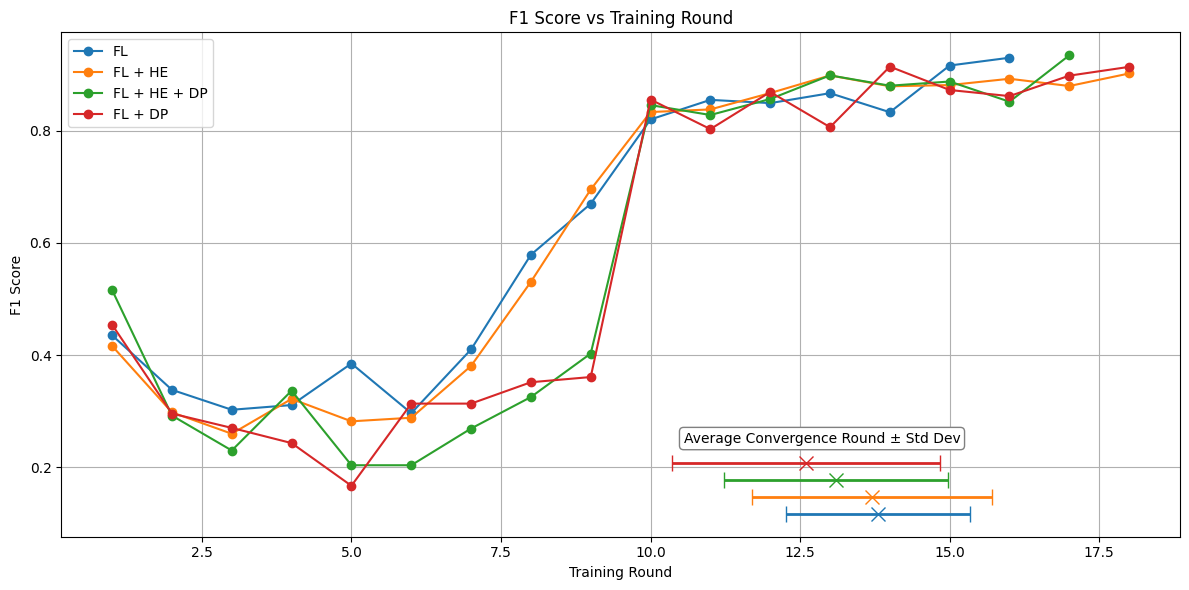

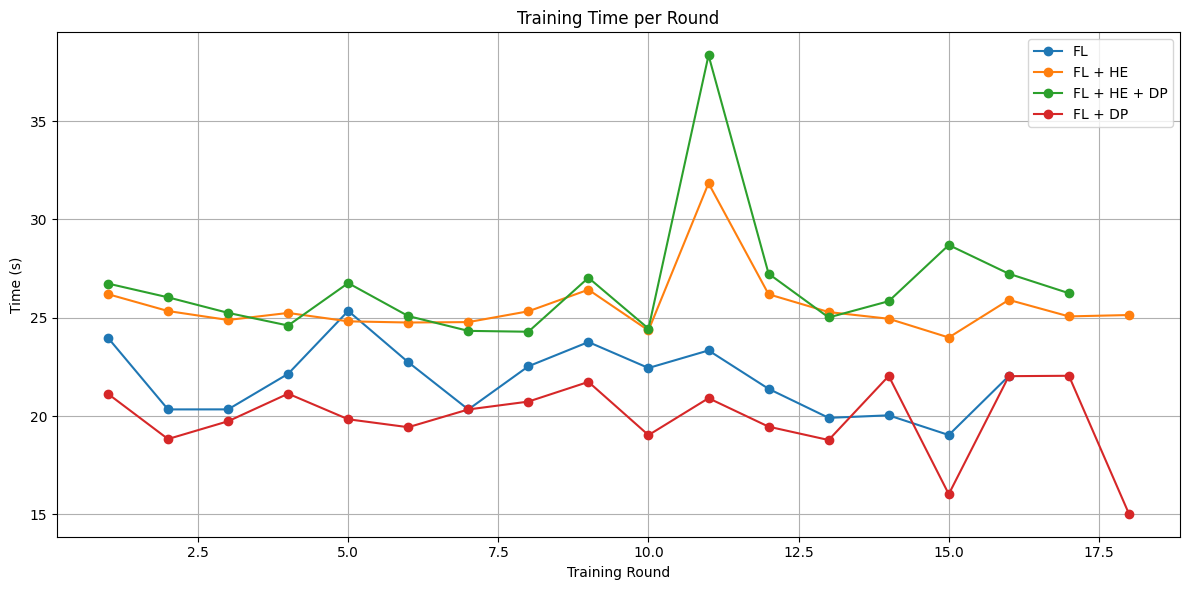

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Toggle STDev Visualization 
SHOW_STD_DEV = False    # Set to False to hide all std visualization
USE_ERROR_BARS = False     # If SHOW_STD_DEV is True choose between error bars or shaded area


max_rounds = 0
f1_stats = {}
time_stats = {}

# Compute max rounds and gather data
for config, runs in all_data.items():
    max_rounds = max(max_rounds, max(len(df) for df in runs if not df.empty))

for config, runs in all_data.items():
    f1_matrix = []
    time_matrix = []
    stop_rounds = []

    for df in runs:
        if df.empty:
            continue
        f1_series = df["F1 Score"].values
        time_series = df["Round Duration (s)"].values
        stop_rounds.append(len(f1_series))

        f1_padded = np.full(max_rounds, np.nan)
        time_padded = np.full(max_rounds, np.nan)
        f1_padded[:len(f1_series)] = f1_series
        time_padded[:len(time_series)] = time_series

        f1_matrix.append(f1_padded)
        time_matrix.append(time_padded)

    f1_array = np.vstack(f1_matrix)
    time_array = np.vstack(time_matrix)

    f1_stats[config] = {
        "mean": np.nanmean(f1_array, axis=0),
        "std": np.nanstd(f1_array, axis=0),
        "stop_rounds": stop_rounds
    }

    time_stats[config] = {
        "mean": np.nanmean(time_array, axis=0),
        "std": np.nanstd(time_array, axis=0),
        "stop_rounds": stop_rounds
    }

rounds = np.arange(1, max_rounds + 1)
colors = plt.cm.tab10.colors

# F1 Score Plot w
plt.figure(figsize=(12, 6))

#marker positioning
min_y = np.inf
for stats in f1_stats.values():
    min_y = min(min_y, np.nanmin(stats["mean"]))
base_marker_y = min_y - 0.05  
marker_spacing = 0.03         
stacked_y_positions = {}

#plot each configs stat
for idx, (config, stats) in enumerate(f1_stats.items()):
    mean = stats["mean"]
    std = stats["std"]
    stop_rounds = stats["stop_rounds"]
    color = colors[idx]

    #Plot main F1 curve
    if SHOW_STD_DEV:
        if USE_ERROR_BARS:
            plt.errorbar(rounds, mean, yerr=std, label=config, fmt='-o', capsize=4, color=color)
        else:
            plt.plot(rounds, mean, label=config, color=color)
            plt.fill_between(rounds, mean - std, mean + std, alpha=0.3, color=color)
    else:
        plt.plot(rounds, mean, label=config, color=color, marker='o')

    # Average convergence marker 
    avg_stop = np.mean(stop_rounds)
    std_stop = np.std(stop_rounds)
    stacked_y = base_marker_y + idx * marker_spacing
    stacked_y_positions[config] = stacked_y  # save for optional annotations

    plt.errorbar(avg_stop, stacked_y, xerr=std_stop, fmt='x', color=color,
                 markersize=10, capsize=6, elinewidth=2, label=None)

#Add annotation above top marker
top_label_y = base_marker_y + (len(f1_stats)) * marker_spacing - 0.05
plt.annotate("Average Convergence Round ± Std Dev",
             xy=(0.68, top_label_y), xycoords='axes fraction',
             ha='center', fontsize=10,
             bbox=dict(boxstyle="round", fc="white", ec="gray"))

# Final plot settings
plt.title("F1 Score vs Training Round")
plt.xlabel("Training Round")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




# Training Time Plot 
plt.figure(figsize=(12, 6))
for idx, (config, stats) in enumerate(time_stats.items()):
    mean = stats["mean"]
    std = stats["std"]

    if SHOW_STD_DEV:
        if USE_ERROR_BARS:
            plt.errorbar(rounds, mean, yerr=std, label=config, fmt='-o', capsize=4, color=colors[idx])
        else:
            plt.plot(rounds, mean, label=config, color=colors[idx])
            plt.fill_between(rounds, mean - std, mean + std, alpha=0.3, color=colors[idx])
    else:
        plt.plot(rounds, mean, label=config, color=colors[idx], marker='o')

plt.title("Training Time per Round")
plt.xlabel("Training Round")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
